In [1]:
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import os


In [2]:
# Only load current results, with no initial guess runs.
result_files = glob.glob("../results/2023_4090/*aa*.json")
len(result_files)


8

In [3]:
# Pull the runs out of the results files
runs = pd.DataFrame()
for filename in result_files:
    with open(filename, "r") as f:
        j = json.load(f)
        rd = pd.DataFrame([l["run"] for l in j if "run" in l])
        runs = runs.append(rd, ignore_index=True)
runs.head()


,ACr Count,ACr Size,Average Turns,Big Regions,Color Count,Elapsed (s),FDOpt Games,FDOpt Regions,Initial Guess,Max Turns,...,Scores,Solver,Strategy,Time,Tiny Games,Tiny Regions,Total Codewords,Total Turns,Use Sym Opt,Verification
0,0,0,3.031250,0,2,0.004863,33,7,11122,4,...,1146,CUDA,Knuth,2023-10-14T01:48:40-0700,32,24,32,97,False,Verified
1,0,0,3.031250,0,2,0.002313,33,7,11122,4,...,1146,CUDA,Most Parts,2023-10-14T01:48:40-0700,32,25,32,97,False,Verified
2,0,0,3.031250,0,2,0.003054,33,7,11122,4,...,1146,CUDA,Expected Size,2023-10-14T01:48:40-0700,32,25,32,97,False,Verified
3,0,0,3.031250,0,2,0.002168,33,7,11122,4,...,1146,CUDA,Entropy,2023-10-14T01:48:40-0700,32,25,32,97,False,Verified
4,0,0,3.407407,5,3,0.003183,171,33,11122,4,...,63357,CUDA,Knuth,2023-10-14T01:48:40-0700,269,216,243,828,False,Verified


In [4]:
# Add some computed columns
runs['Scores per Second'] = runs['Scores'] / runs['Elapsed (s)']


In [5]:
def log_plot_with_400k_marker(data, data_dashed, title, y_title):
    fig, ax = plt.subplots(figsize=(16, 9))
    plt.rcParams.update({'font.size': 14})
    ax.set_yscale('log')

    unique_c_values = data.columns.tolist()
    for p in data.index.tolist():
        values = data.loc[p]
        line, = ax.plot(unique_c_values, values, label=f'P={p}')
        if p in data_dashed.index:
            values2 = data_dashed.loc[p]
            ax.plot(data_dashed.columns, values2, linestyle="dashed", color=line.get_color())

    ax.set_xlabel('C')
    ax.set_xticks(unique_c_values)
    ax.set_ylabel(y_title + ' (log scale)')
    ax.legend()
    ax.set_title(title)
    plt.grid(True)
    return plt


In [6]:
# Let's focus on results using Knuth's algorithm
knuth_runs = runs[(runs['Strategy'] == 'Knuth')]
knuth_runs_biggies = knuth_runs[knuth_runs['Color Count'].pow(knuth_runs['Pin Count']) > 400000]


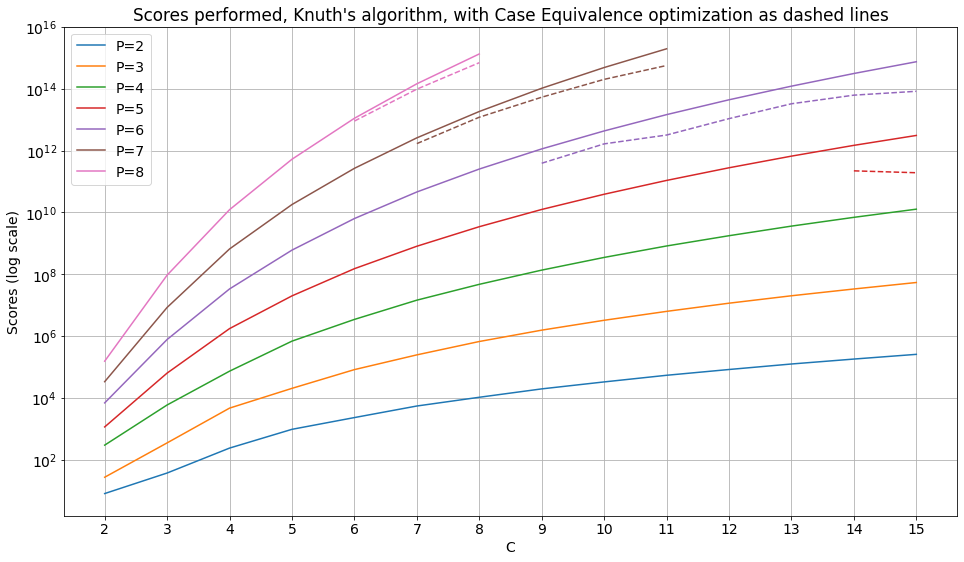

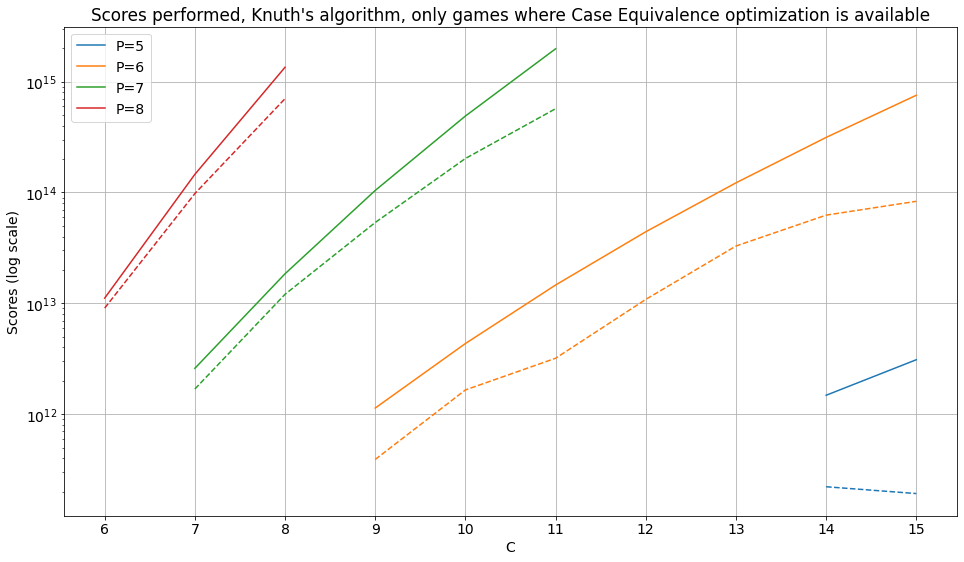

In [8]:
def plot_opt_noopt(runs, title):
    runs_opt = runs[runs['Use Sym Opt']]
    runs_noopt = runs[~runs['Use Sym Opt']]
    scores_opt = runs_opt.pivot_table(index='Pin Count', columns='Color Count', values='Scores', aggfunc='max')
    scores_noopt = runs_noopt.pivot_table(index='Pin Count', columns='Color Count', values='Scores', aggfunc='max')
    return log_plot_with_400k_marker(scores_noopt, scores_opt, title,
                                     "Scores")


plt = plot_opt_noopt(knuth_runs, "Scores performed, Knuth's algorithm, with Case Equivalence optimization as dashed lines")
plt.savefig('scores_knuth_ce_all.jpg', dpi=150)
plt.show()

plt = plot_opt_noopt(knuth_runs_biggies, "Scores performed, Knuth's algorithm, only games where Case Equivalence optimization is available")
plt.savefig('scores_knuth_ce_big.jpg', dpi=150)
plt.show()
